In [1]:
from loaders import load_adult

In [2]:
import matplotlib.pyplot as plt
import pandas as pd

df = load_adult()

### Exploratory Data Analysis

Source for some of this code: https://www.valentinmihov.com/2015/04/17/adult-income-data-set/

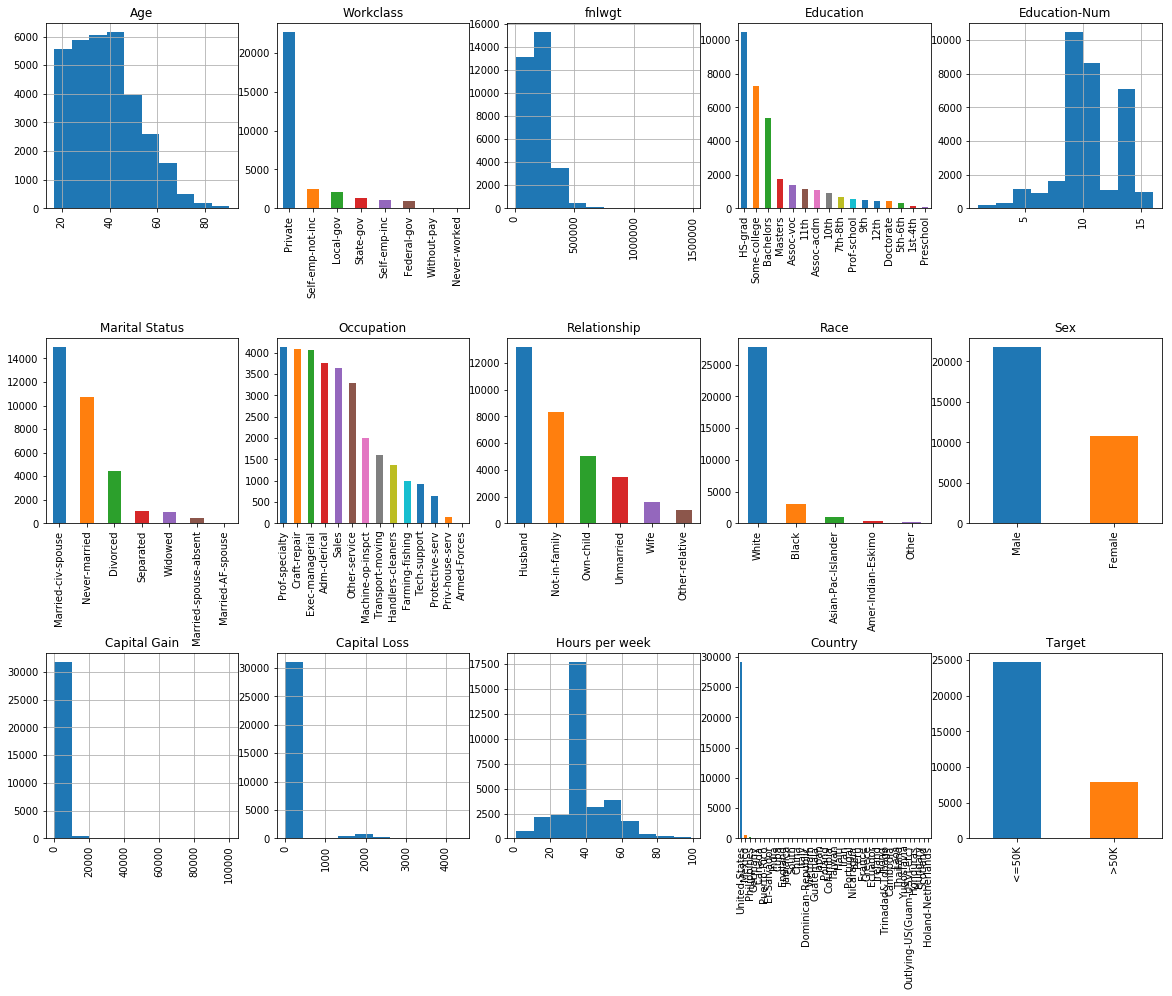

In [3]:
from math import ceil
import numpy as np

fig = plt.figure(figsize=(20,15))
cols = 5
original_data = df
rows = ceil(float(original_data.shape[1]) / cols)
for i, column in enumerate(original_data.columns):
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.set_title(column)
    if original_data.dtypes[column] == np.object:
        original_data[column].value_counts().plot(kind="bar", axes=ax)
    else:
        original_data[column].hist(axes=ax)
        plt.xticks(rotation="vertical")
plt.subplots_adjust(hspace=0.7, wspace=0.2)

### Deal with missing data 

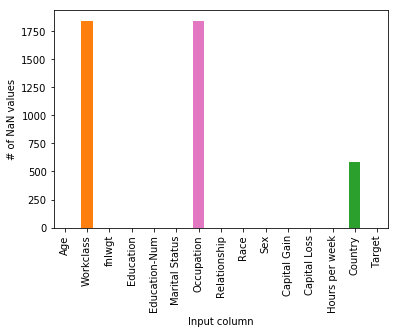

In [4]:
df.isna().sum().plot(kind='bar')
plt.ylabel('# of NaN values')
plt.xlabel('Input column')
plt.show()

In [5]:
# Remove missing data
df = df.dropna()

### Preprocess data

Perform one-hot-encoding using `pd.get_dummies()`. This will transform categorical data into dummy/indicator variables.

In [6]:
df = pd.get_dummies(df)

# Want the target to be 0 or 1
df['Target'] = df['Target_>50K']
del df["Target_<=50K"]
del df["Target_>50K"]

In [7]:
with pd.option_context('display.max_seq_items', None):
    print(df.columns)

Index(['Age', 'fnlwgt', 'Education-Num', 'Capital Gain', 'Capital Loss',
       'Hours per week', 'Workclass_Federal-gov', 'Workclass_Local-gov',
       'Workclass_Private', 'Workclass_Self-emp-inc',
       'Workclass_Self-emp-not-inc', 'Workclass_State-gov',
       'Workclass_Without-pay', 'Education_10th', 'Education_11th',
       'Education_12th', 'Education_1st-4th', 'Education_5th-6th',
       'Education_7th-8th', 'Education_9th', 'Education_Assoc-acdm',
       'Education_Assoc-voc', 'Education_Bachelors', 'Education_Doctorate',
       'Education_HS-grad', 'Education_Masters', 'Education_Preschool',
       'Education_Prof-school', 'Education_Some-college',
       'Marital Status_Divorced', 'Marital Status_Married-AF-spouse',
       'Marital Status_Married-civ-spouse',
       'Marital Status_Married-spouse-absent', 'Marital Status_Never-married',
       'Marital Status_Separated', 'Marital Status_Widowed',
       'Occupation_Adm-clerical', 'Occupation_Armed-Forces',
       'Occupat

Note that the above list of columns does not include NA or ? enumerations. The one-hot-encoding scheme simply transforms those into zeros across all options.

### Split data into training and testing

In [8]:
from sklearn.model_selection import train_test_split

X = df[[c for c in df.columns if c != 'Target']]
y = df['Target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=1)

### Scale Data

Do I have to build a pipeline and scale the data each time the algorithm runs, or can I just scale it up front?

In [9]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Decision Tree

In [10]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier()

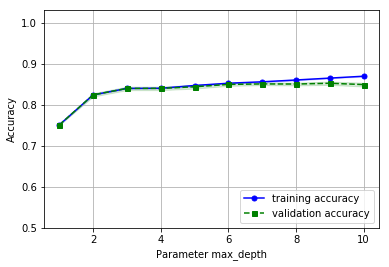

In [11]:
from plotters import plot_validation_curve

train_mean, train_std, test_mean, test_std = plot_validation_curve(estimator=tree, X_train=X_train, y_train=y_train, param_name='max_depth', param_range=range(1, 11))

In [12]:
max_depth = 1 + np.argmax(test_mean)
max_acc = test_mean[max_depth - 1]
print('Maximum testing accuracy of %.3f achieved with max_depth %i.' % (max_acc, max_depth))

Maximum testing accuracy of 0.853 achieved with max_depth 9.


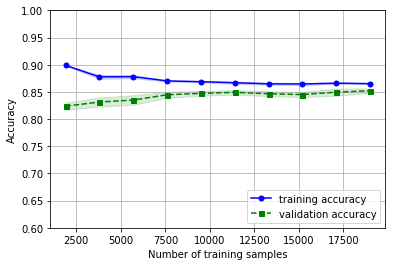

(array([ 0.89873684,  0.87763158,  0.87803509,  0.87021053,  0.86872632,
         0.86691228,  0.86484962,  0.86454605,  0.86604678,  0.86514394]),
 array([ 0.00063158,  0.00369547,  0.00293858,  0.0011757 ,  0.00138248,
         0.00198051,  0.00172941,  0.00214245,  0.00090339,  0.00066662]),
 array([ 0.82371138,  0.83138227,  0.83502852,  0.84473925,  0.8473449 ,
         0.84919277,  0.84653905,  0.84516563,  0.84947778,  0.85222408]),
 array([ 0.00661734,  0.0084658 ,  0.0088174 ,  0.005633  ,  0.00444976,
         0.0041833 ,  0.00457284,  0.00473404,  0.00665   ,  0.0042464 ]))

In [13]:
from plotters import plot_learning_curve

tree = DecisionTreeClassifier(max_depth=max_depth)
plot_learning_curve(tree, X_train, y_train)

## Neural Nets

In [14]:
from sklearn.neural_network import MLPClassifier

base_clf = MLPClassifier(
    activation='logistic',
    solver='sgd',
)

possible_hyperparams = [
    'hidden_layer_sizes',
    'alpha', # L2 regularization
    'learning_rate_init',
    'momentum'
]

In [15]:
# Perform grid search for more coverage
# Programmatically determine layer sizes
from math import ceil

n_features = X_train.shape[1]
layer_sizes = [ceil(n) for n in [1/4 * n_features, 1/2*n_features, 3/4* n_features, n_features, 2*n_features]]

hyperparams = {
    'hidden_layer_sizes': layer_sizes,
    'learning_rate_init': [.0005, .001, .005, .010],
    'momentum': [.7, .8, .9, .95]
}
from pprint import pprint
print(n_features)
pprint(hyperparams)

104
{'hidden_layer_sizes': [26, 52, 78, 104, 208],
 'learning_rate_init': [0.0005, 0.001, 0.005, 0.01],
 'momentum': [0.7, 0.8, 0.9, 0.95]}


## Comparison of Keras and Scikit-learn

I'm interested in run time comparison.

In [16]:
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import SGD
from keras.wrappers.scikit_learn import KerasClassifier

def build_keras_clf(hidden_layer_sizes, learning_rate_init, momentum):
    """This function builds a Keras model for use with scikit's GridSearch"""
    if not isinstance(hidden_layer_sizes, tuple):
        hidden_layer_sizes = (hidden_layer_sizes,)
    
    model = Sequential()
    model.add(Dense(units=n_features, input_shape=(n_features,)))
    
    for layer_size in hidden_layer_sizes:
        model.add(Dense(units=layer_size))
    
    # Add output layer
    model.add(Dense(units=1))
        
    sgd = SGD(lr=learning_rate_init, momentum=momentum, nesterov=True)
    model.compile(loss='mean_squared_error', optimizer=sgd, metrics=["accuracy"])
    
    return model

keras_clf = KerasClassifier(build_fn=build_keras_clf)

Using TensorFlow backend.


In [17]:
from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(
    estimator=keras_clf,
    param_grid=hyperparams,
    verbose=1000,
    n_jobs=1
)

In [18]:
grid_search.fit(X_train_scaled, y_train)

Fitting 3 folds for each of 80 candidates, totalling 240 fits
[CV] hidden_layer_sizes=26, learning_rate_init=0.0005, momentum=0.7 ..
Epoch 1/1
14075/14075 [==============================] - 0s 27us/step
[CV]  hidden_layer_sizes=26, learning_rate_init=0.0005, momentum=0.7, score=0.8215402103547651, total=   1.1s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s
[CV] hidden_layer_sizes=26, learning_rate_init=0.0005, momentum=0.7 ..
Epoch 1/1
14075/14075 [==============================] - 0s 28us/step
[CV]  hidden_layer_sizes=26, learning_rate_init=0.0005, momentum=0.7, score=0.8306337026717752, total=   1.2s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.1s remaining:    0.0s
[CV] hidden_layer_sizes=26, learning_rate_init=0.0005, momentum=0.7 ..
Epoch 1/1
14076/14076 [==============================] - 0s 32us/step
[CV]  hidden_layer_sizes=26, learning_rate_init=0.0005, momentum=0.7, score=0.8347307091259357, total=   1.2s
[Parallel(n_jobs=1)]: Don

Epoch 1/1
14076/14076 [==============================] - 0s 19us/step
[CV]  hidden_layer_sizes=26, learning_rate_init=0.001, momentum=0.8, score=0.8323149068612715, total=   1.4s
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:   31.1s remaining:    0.0s
[CV] hidden_layer_sizes=26, learning_rate_init=0.001, momentum=0.9 ...
Epoch 1/1
14075/14075 [==============================] - 0s 21us/step
[CV]  hidden_layer_sizes=26, learning_rate_init=0.001, momentum=0.9, score=0.8145780050303998, total=   1.4s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:   32.8s remaining:    0.0s
[CV] hidden_layer_sizes=26, learning_rate_init=0.001, momentum=0.9 ...
Epoch 1/1
14075/14075 [==============================] - 0s 20us/step 
[CV]  hidden_layer_sizes=26, learning_rate_init=0.001, momentum=0.9, score=0.8267973856547909, total=   1.5s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:   34.5s remaining:    0.0s
[CV] hidden_layer_sizes=26, learning_rate_init=0.001, momentum=0.9 ...
Epoch 1/1

14075/14075 [==============================] - 1s 43us/step
[CV]  hidden_layer_sizes=26, learning_rate_init=0.005, momentum=0.95, score=0.0, total=   2.0s
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:  1.1min remaining:    0.0s
[CV] hidden_layer_sizes=26, learning_rate_init=0.005, momentum=0.95 ..
Epoch 1/1
14076/14076 [==============================] - 0s 23us/step
[CV]  hidden_layer_sizes=26, learning_rate_init=0.005, momentum=0.95, score=0.0, total=   2.0s
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:  1.1min remaining:    0.0s
[CV] hidden_layer_sizes=26, learning_rate_init=0.01, momentum=0.7 ....
Epoch 1/1
14075/14075 [==============================] - 1s 40us/step
[CV]  hidden_layer_sizes=26, learning_rate_init=0.01, momentum=0.7, score=0.8127308895080461, total=   2.2s
[Parallel(n_jobs=1)]: Done  37 out of  37 | elapsed:  1.2min remaining:    0.0s
[CV] hidden_layer_sizes=26, learning_rate_init=0.01, momentum=0.7 ....
Epoch 1/1
14075/14075 [==========================

Epoch 1/1
14075/14075 [==============================] - 0s 27us/step
[CV]  hidden_layer_sizes=52, learning_rate_init=0.0005, momentum=0.8, score=0.8188405796254552, total=   2.1s
[Parallel(n_jobs=1)]: Done  53 out of  53 | elapsed:  1.9min remaining:    0.0s
[CV] hidden_layer_sizes=52, learning_rate_init=0.0005, momentum=0.8 ..
Epoch 1/1
14076/14076 [==============================] - 0s 27us/step
[CV]  hidden_layer_sizes=52, learning_rate_init=0.0005, momentum=0.8, score=0.8293306807216738, total=   2.3s
[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed:  1.9min remaining:    0.0s
[CV] hidden_layer_sizes=52, learning_rate_init=0.0005, momentum=0.9 ..
Epoch 1/1
14075/14075 [==============================] - 0s 27us/step
[CV]  hidden_layer_sizes=52, learning_rate_init=0.0005, momentum=0.9, score=0.8229610684006754, total=   2.3s
[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed:  2.0min remaining:    0.0s
[CV] hidden_layer_sizes=52, learning_rate_init=0.0005, momentum=0.9 ..
Epoch 1

14075/14075 [==============================] - 0s 34us/step
[CV]  hidden_layer_sizes=52, learning_rate_init=0.001, momentum=0.95, score=0.822961068553117, total=   3.4s
[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:  2.8min remaining:    0.0s
[CV] hidden_layer_sizes=52, learning_rate_init=0.001, momentum=0.95 ..
Epoch 1/1
14075/14075 [==============================] - 1s 37us/step
[CV]  hidden_layer_sizes=52, learning_rate_init=0.001, momentum=0.95, score=0.8287865871324834, total=   3.0s
[Parallel(n_jobs=1)]: Done  71 out of  71 | elapsed:  2.8min remaining:    0.0s
[CV] hidden_layer_sizes=52, learning_rate_init=0.001, momentum=0.95 ..
Epoch 1/1
14076/14076 [==============================] - 1s 38us/step
[CV]  hidden_layer_sizes=52, learning_rate_init=0.001, momentum=0.95, score=0.8281938327092313, total=   2.9s
[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:  2.9min remaining:    0.0s
[CV] hidden_layer_sizes=52, learning_rate_init=0.005, momentum=0.7 ...
Epoch 1/1
14075/14

Epoch 1/1
14075/14075 [==============================] - 0s 34us/step
[CV]  hidden_layer_sizes=52, learning_rate_init=0.01, momentum=0.8, score=0.0, total=   3.6s
[Parallel(n_jobs=1)]: Done  88 out of  88 | elapsed:  3.9min remaining:    0.0s
[CV] hidden_layer_sizes=52, learning_rate_init=0.01, momentum=0.8 ....
Epoch 1/1
14075/14075 [==============================] - 1s 40us/step
[CV]  hidden_layer_sizes=52, learning_rate_init=0.01, momentum=0.8, score=0.0, total=   3.7s
[Parallel(n_jobs=1)]: Done  89 out of  89 | elapsed:  4.0min remaining:    0.0s
[CV] hidden_layer_sizes=52, learning_rate_init=0.01, momentum=0.8 ....
Epoch 1/1
14076/14076 [==============================] - 1s 38us/step
[CV]  hidden_layer_sizes=52, learning_rate_init=0.01, momentum=0.8, score=0.0, total=   3.3s
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:  4.0min remaining:    0.0s
[CV] hidden_layer_sizes=52, learning_rate_init=0.01, momentum=0.9 ....
Epoch 1/1
14075/14075 [==============================] - 1

14076/14076 [==============================] - 1s 61us/step
[CV]  hidden_layer_sizes=78, learning_rate_init=0.0005, momentum=0.9, score=0.8283359386271436, total=   4.4s
[Parallel(n_jobs=1)]: Done 105 out of 105 | elapsed:  5.2min remaining:    0.0s
[CV] hidden_layer_sizes=78, learning_rate_init=0.0005, momentum=0.95 .
Epoch 1/1
14075/14075 [==============================] - 1s 80us/step
[CV]  hidden_layer_sizes=78, learning_rate_init=0.0005, momentum=0.95, score=0.8198351804998051, total=   4.5s
[Parallel(n_jobs=1)]: Done 106 out of 106 | elapsed:  5.3min remaining:    0.0s
[CV] hidden_layer_sizes=78, learning_rate_init=0.0005, momentum=0.95 .
Epoch 1/1
14075/14075 [==============================] - 1s 60us/step
[CV]  hidden_layer_sizes=78, learning_rate_init=0.0005, momentum=0.95, score=0.8191247513836912, total=   4.2s
[Parallel(n_jobs=1)]: Done 107 out of 107 | elapsed:  5.4min remaining:    0.0s
[CV] hidden_layer_sizes=78, learning_rate_init=0.0005, momentum=0.95 .
Epoch 1/1
14076

Epoch 1/1
14076/14076 [==============================] - 1s 58us/step
[CV]  hidden_layer_sizes=78, learning_rate_init=0.005, momentum=0.7, score=0.8189569418955818, total=   4.6s
[Parallel(n_jobs=1)]: Done 123 out of 123 | elapsed:  6.8min remaining:    0.0s
[CV] hidden_layer_sizes=78, learning_rate_init=0.005, momentum=0.8 ...
Epoch 1/1
14075/14075 [==============================] - 1s 57us/step
[CV]  hidden_layer_sizes=78, learning_rate_init=0.005, momentum=0.8, score=0.0, total=   5.2s
[Parallel(n_jobs=1)]: Done 124 out of 124 | elapsed:  6.9min remaining:    0.0s
[CV] hidden_layer_sizes=78, learning_rate_init=0.005, momentum=0.8 ...
Epoch 1/1
14075/14075 [==============================] - 1s 62us/step
[CV]  hidden_layer_sizes=78, learning_rate_init=0.005, momentum=0.8, score=0.8196930945444663, total=   4.9s
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:  7.0min remaining:    0.0s
[CV] hidden_layer_sizes=78, learning_rate_init=0.005, momentum=0.8 ...
Epoch 1/1
14076/14076 [==

Epoch 1/1
14076/14076 [==============================] - 1s 62us/step
[CV]  hidden_layer_sizes=78, learning_rate_init=0.01, momentum=0.9, score=0.0, total=   5.1s
[Parallel(n_jobs=1)]: Done 141 out of 141 | elapsed:  8.6min remaining:    0.0s
[CV] hidden_layer_sizes=78, learning_rate_init=0.01, momentum=0.95 ...
Epoch 1/1
14075/14075 [==============================] - 1s 58us/step
[CV]  hidden_layer_sizes=78, learning_rate_init=0.01, momentum=0.95, score=0.0, total=   5.1s
[Parallel(n_jobs=1)]: Done 142 out of 142 | elapsed:  8.7min remaining:    0.0s
[CV] hidden_layer_sizes=78, learning_rate_init=0.01, momentum=0.95 ...
Epoch 1/1
14075/14075 [==============================] - 1s 56us/step
[CV]  hidden_layer_sizes=78, learning_rate_init=0.01, momentum=0.95, score=0.0, total=   5.3s
[Parallel(n_jobs=1)]: Done 143 out of 143 | elapsed:  8.8min remaining:    0.0s
[CV] hidden_layer_sizes=78, learning_rate_init=0.01, momentum=0.95 ...
Epoch 1/1
14076/14076 [==============================] -

14075/14075 [==============================] - 1s 67us/step
[CV]  hidden_layer_sizes=104, learning_rate_init=0.001, momentum=0.7, score=0.8275078147539668, total=   5.5s
[Parallel(n_jobs=1)]: Done 158 out of 158 | elapsed: 10.4min remaining:    0.0s
[CV] hidden_layer_sizes=104, learning_rate_init=0.001, momentum=0.7 ..
Epoch 1/1
14076/14076 [==============================] - 1s 73us/step
[CV]  hidden_layer_sizes=104, learning_rate_init=0.001, momentum=0.7, score=0.8279096206701224, total=   5.7s
[Parallel(n_jobs=1)]: Done 159 out of 159 | elapsed: 10.5min remaining:    0.0s
[CV] hidden_layer_sizes=104, learning_rate_init=0.001, momentum=0.8 ..
Epoch 1/1
14075/14075 [==============================] - 1s 68us/step
[CV]  hidden_layer_sizes=104, learning_rate_init=0.001, momentum=0.8, score=0.8232452401927873, total=   5.7s
[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed: 10.6min remaining:    0.0s
[CV] hidden_layer_sizes=104, learning_rate_init=0.001, momentum=0.8 ..
Epoch 1/1
14075/1

14075/14075 [==============================] - 1s 63us/step
[CV]  hidden_layer_sizes=104, learning_rate_init=0.005, momentum=0.9, score=0.0, total=   6.1s
[Parallel(n_jobs=1)]: Done 175 out of 175 | elapsed: 12.3min remaining:    0.0s
[CV] hidden_layer_sizes=104, learning_rate_init=0.005, momentum=0.9 ..
Epoch 1/1
14075/14075 [==============================] - 1s 67us/step
[CV]  hidden_layer_sizes=104, learning_rate_init=0.005, momentum=0.9, score=0.0, total=   6.4s
[Parallel(n_jobs=1)]: Done 176 out of 176 | elapsed: 12.4min remaining:    0.0s
[CV] hidden_layer_sizes=104, learning_rate_init=0.005, momentum=0.9 ..
Epoch 1/1
14076/14076 [==============================] - 1s 81us/step
[CV]  hidden_layer_sizes=104, learning_rate_init=0.005, momentum=0.9, score=0.0, total=   6.1s
[Parallel(n_jobs=1)]: Done 177 out of 177 | elapsed: 12.5min remaining:    0.0s
[CV] hidden_layer_sizes=104, learning_rate_init=0.005, momentum=0.95 .
Epoch 1/1
14075/14075 [==============================] - 1s 76

Epoch 1/1
14075/14075 [==============================] - 1s 76us/step
[CV]  hidden_layer_sizes=208, learning_rate_init=0.0005, momentum=0.7, score=0.8223927252568383, total=   6.6s
[Parallel(n_jobs=1)]: Done 193 out of 193 | elapsed: 14.6min remaining:    0.0s
[CV] hidden_layer_sizes=208, learning_rate_init=0.0005, momentum=0.7 .
Epoch 1/1
14075/14075 [==============================] - 1s 100us/step
[CV]  hidden_layer_sizes=208, learning_rate_init=0.0005, momentum=0.7, score=0.8316283034106214, total=   7.4s
[Parallel(n_jobs=1)]: Done 194 out of 194 | elapsed: 14.7min remaining:    0.0s
[CV] hidden_layer_sizes=208, learning_rate_init=0.0005, momentum=0.7 .
Epoch 1/1
14076/14076 [==============================] - 1s 88us/step
[CV]  hidden_layer_sizes=208, learning_rate_init=0.0005, momentum=0.7, score=0.8188148359607291, total=   7.4s
[Parallel(n_jobs=1)]: Done 195 out of 195 | elapsed: 14.9min remaining:    0.0s
[CV] hidden_layer_sizes=208, learning_rate_init=0.0005, momentum=0.8 .
Epo

14076/14076 [==============================] - 1s 93us/step
[CV]  hidden_layer_sizes=208, learning_rate_init=0.001, momentum=0.8, score=0.8037515986333335, total=   8.2s
[Parallel(n_jobs=1)]: Done 210 out of 210 | elapsed: 17.2min remaining:    0.0s
[CV] hidden_layer_sizes=208, learning_rate_init=0.001, momentum=0.9 ..
Epoch 1/1
14075/14075 [==============================] - 1s 81us/step
[CV]  hidden_layer_sizes=208, learning_rate_init=0.001, momentum=0.9, score=0.8185564081043505, total=   7.5s
[Parallel(n_jobs=1)]: Done 211 out of 211 | elapsed: 17.3min remaining:    0.0s
[CV] hidden_layer_sizes=208, learning_rate_init=0.001, momentum=0.9 ..
Epoch 1/1
14075/14075 [==============================] - 1s 89us/step
[CV]  hidden_layer_sizes=208, learning_rate_init=0.001, momentum=0.9, score=0.8077578856613732, total=   7.8s
[Parallel(n_jobs=1)]: Done 212 out of 212 | elapsed: 17.5min remaining:    0.0s
[CV] hidden_layer_sizes=208, learning_rate_init=0.001, momentum=0.9 ..
Epoch 1/1
14076/1

[CV]  hidden_layer_sizes=208, learning_rate_init=0.005, momentum=0.95, score=0.0, total=   8.2s
[Parallel(n_jobs=1)]: Done 227 out of 227 | elapsed: 19.8min remaining:    0.0s
[CV] hidden_layer_sizes=208, learning_rate_init=0.005, momentum=0.95 .
Epoch 1/1
14076/14076 [==============================] - 1s 100us/step
[CV]  hidden_layer_sizes=208, learning_rate_init=0.005, momentum=0.95, score=0.0, total=   8.8s
[Parallel(n_jobs=1)]: Done 228 out of 228 | elapsed: 20.0min remaining:    0.0s
[CV] hidden_layer_sizes=208, learning_rate_init=0.01, momentum=0.7 ...
Epoch 1/1
14075/14075 [==============================] - 1s 85us/step
[CV]  hidden_layer_sizes=208, learning_rate_init=0.01, momentum=0.7, score=0.0, total=   8.1s
[Parallel(n_jobs=1)]: Done 229 out of 229 | elapsed: 20.1min remaining:    0.0s
[CV] hidden_layer_sizes=208, learning_rate_init=0.01, momentum=0.7 ...
Epoch 1/1
14075/14075 [==============================] - 1s 98us/step
[CV]  hidden_layer_sizes=208, learning_rate_init=0

GridSearchCV(cv=None, error_score='raise',
       estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x7f4057a43400>,
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'hidden_layer_sizes': [26, 52, 78, 104, 208], 'learning_rate_init': [0.0005, 0.001, 0.005, 0.01], 'momentum': [0.7, 0.8, 0.9, 0.95]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1000)

In [22]:
grid_search_keras = grid_search
grid_search_keras.cv_results_['mean_fit_time']

array([ 0.95458436,  1.04656553,  1.06436284,  1.08704408,  1.09959674,
        1.20095515,  1.1205434 ,  1.04157186,  1.13583755,  1.44484584,
        1.31350501,  1.52907443,  1.4859972 ,  1.5380195 ,  1.9434104 ,
        1.5852197 ,  1.77252491,  1.62607074,  1.68856676,  1.79105544,
        1.98788102,  2.00389703,  2.25776823,  2.33270295,  2.57766239,
        2.48683643,  2.20217133,  2.30369266,  2.24644518,  2.5263203 ,
        2.4198664 ,  2.45294182,  2.65822331,  3.31777143,  3.37436906,
        3.14509583,  3.15233135,  3.34807825,  3.72283634,  3.17052102,
        3.3378137 ,  3.48246598,  3.45675453,  3.5088857 ,  3.79322902,
        3.38408836,  3.60359271,  3.6996963 ,  3.58680797,  3.86604524,
        3.74652179,  4.5254976 ,  3.8463041 ,  4.00598598,  4.32655303,
        4.2059776 ,  4.20194014,  4.14755464,  4.40543214,  4.53579688,
        4.45616595,  4.80549407,  4.71658468,  4.96326764,  5.0520827 ,
        5.42432038,  5.31193113,  5.42210976,  5.64830033,  5.64

In [23]:
from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(
    estimator=base_clf,
    param_grid=hyperparams,
    verbose=1000,
    n_jobs=-1
)

In [24]:
grid_search.fit(X_train_scaled, y_train)

Fitting 3 folds for each of 80 candidates, totalling 240 fits
[CV] hidden_layer_sizes=26, learning_rate_init=0.0005, momentum=0.7 ..
[CV] hidden_layer_sizes=26, learning_rate_init=0.0005, momentum=0.7 ..
Memmaping (shape=(21113, 104), dtype=float64) to new file /dev/shm/joblib_memmaping_pool_142_139914102756352/142-139912952431392-08d56fd54e0509e090d90ca756f3e039.pkl
Pickling array (shape=(21113,), dtype=int64).
Pickling array (shape=(21113,), dtype=uint8).
Pickling array (shape=(21113,), dtype=int64).
Pickling array (shape=(14075,), dtype=int64).
Pickling array (shape=(7038,), dtype=int64).
Memmaping (shape=(21113, 104), dtype=float64) to old file /dev/shm/joblib_memmaping_pool_142_139914102756352/142-139912952431392-08d56fd54e0509e090d90ca756f3e039.pkl
Pickling array (shape=(21113,), dtype=int64).
Pickling array (shape=(21113,), dtype=uint8).
Pickling array (shape=(21113,), dtype=int64).
Pickling array (shape=(14075,), dtype=int64).
Pickling array (shape=(7038,), dtype=int64).
Memmap

/opt/conda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  hidden_layer_sizes=26, learning_rate_init=0.0005, momentum=0.7, score=0.8310359528208043, total=  38.8s
[CV] hidden_layer_sizes=26, learning_rate_init=0.0005, momentum=0.8 ..


/opt/conda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   40.4s
Memmaping (shape=(21113, 104), dtype=float64) to old file /dev/shm/joblib_memmaping_pool_142_139914102756352/142-139912952431392-08d56fd54e0509e090d90ca756f3e039.pkl
Pickling array (shape=(21113,), dtype=int64).
Pickling array (shape=(21113,), dtype=uint8).
Pickling array (shape=(21113,), dtype=int64).
Pickling array (shape=(14076,), dtype=int64).
Pickling array (shape=(7037,), dtype=int64).
[CV]  hidden_layer_sizes=26, learning_rate_init=0.0005, momentum=0.8, score=0.8309178743961353, total=  39.9s
[CV] hidden_layer_sizes=26, learning_rate_init=0.0005, momentum=0.8 ..
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   40.7s
Memmaping (shape=(21113, 104), dtype=float64) to old file /dev/shm/joblib_memmaping_pool_142_139914102756352/142-139912952431392-08d56fd54e0509e090d90ca756f3e039.pkl
Pickling array (shape=(21113,), dtype=int64).
Pickling array (shape=(21113,), dtype=uint8).
Pickling array (shape=(21113,), dtype=int6

/opt/conda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  hidden_layer_sizes=26, learning_rate_init=0.0005, momentum=0.7, score=0.8253765274225632, total=  42.1s
[CV] hidden_layer_sizes=26, learning_rate_init=0.0005, momentum=0.9 ..
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:   42.7s
Memmaping (shape=(21113, 104), dtype=float64) to old file /dev/shm/joblib_memmaping_pool_142_139914102756352/142-139912952431392-08d56fd54e0509e090d90ca756f3e039.pkl
Pickling array (shape=(21113,), dtype=int64).
Pickling array (shape=(21113,), dtype=uint8).
Pickling array (shape=(21113,), dtype=int64).
Pickling array (shape=(14075,), dtype=int64).
Pickling array (shape=(7038,), dtype=int64).


/opt/conda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  hidden_layer_sizes=26, learning_rate_init=0.0005, momentum=0.7, score=0.8300653594771242, total=  45.0s
[CV] hidden_layer_sizes=26, learning_rate_init=0.0005, momentum=0.9 ..
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   45.6s
Memmaping (shape=(21113, 104), dtype=float64) to old file /dev/shm/joblib_memmaping_pool_142_139914102756352/142-139912952431392-08d56fd54e0509e090d90ca756f3e039.pkl
Pickling array (shape=(21113,), dtype=int64).
Pickling array (shape=(21113,), dtype=uint8).
Pickling array (shape=(21113,), dtype=int64).
Pickling array (shape=(14076,), dtype=int64).
Pickling array (shape=(7037,), dtype=int64).


/opt/conda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  hidden_layer_sizes=26, learning_rate_init=0.0005, momentum=0.8, score=0.8326229042341574, total=  40.5s
[CV] hidden_layer_sizes=26, learning_rate_init=0.0005, momentum=0.9 ..


/opt/conda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  1.4min
Memmaping (shape=(21113, 104), dtype=float64) to old file /dev/shm/joblib_memmaping_pool_142_139914102756352/142-139912952431392-08d56fd54e0509e090d90ca756f3e039.pkl
Pickling array (shape=(21113,), dtype=int64).
Pickling array (shape=(21113,), dtype=uint8).
Pickling array (shape=(21113,), dtype=int64).
Pickling array (shape=(14075,), dtype=int64).
Pickling array (shape=(7038,), dtype=int64).
[CV]  hidden_layer_sizes=26, learning_rate_init=0.0005, momentum=0.8, score=0.8327412249538155, total=  40.4s
[CV] hidden_layer_sizes=26, learning_rate_init=0.0005, momentum=0.95 .
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:  1.4min
Memmaping (shape=(21113, 104), dtype=float64) to old file /dev/shm/joblib_memmaping_pool_142_139914102756352/142-139912952431392-08d56fd54e0509e090d90ca756f3e039.pkl
Pickling array (shape=(21113,), dtype=int64).
Pickling array (shape=(21113,), dtype=uint8).
Pickling array (shape=(21113,), dtype=int6

/opt/conda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  hidden_layer_sizes=26, learning_rate_init=0.001, momentum=0.7, score=0.8333333333333334, total=  35.7s
[CV] hidden_layer_sizes=26, learning_rate_init=0.001, momentum=0.8 ...
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:  2.4min
Memmaping (shape=(21113, 104), dtype=float64) to old file /dev/shm/joblib_memmaping_pool_142_139914102756352/142-139912952431392-08d56fd54e0509e090d90ca756f3e039.pkl
Pickling array (shape=(21113,), dtype=int64).
Pickling array (shape=(21113,), dtype=uint8).
Pickling array (shape=(21113,), dtype=int64).
Pickling array (shape=(14076,), dtype=int64).
Pickling array (shape=(7037,), dtype=int64).


/opt/conda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  hidden_layer_sizes=26, learning_rate_init=0.001, momentum=0.7, score=0.8381642512077294, total=  35.5s
[CV] hidden_layer_sizes=26, learning_rate_init=0.001, momentum=0.8 ...
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  2.4min
Memmaping (shape=(21113, 104), dtype=float64) to old file /dev/shm/joblib_memmaping_pool_142_139914102756352/142-139912952431392-08d56fd54e0509e090d90ca756f3e039.pkl
Pickling array (shape=(21113,), dtype=int64).
Pickling array (shape=(21113,), dtype=uint8).
Pickling array (shape=(21113,), dtype=int64).
Pickling array (shape=(14075,), dtype=int64).
Pickling array (shape=(7038,), dtype=int64).


/opt/conda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  hidden_layer_sizes=26, learning_rate_init=0.001, momentum=0.7, score=0.8371465112974279, total=  34.6s
[CV] hidden_layer_sizes=26, learning_rate_init=0.001, momentum=0.9 ...
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:  2.5min
Memmaping (shape=(21113, 104), dtype=float64) to old file /dev/shm/joblib_memmaping_pool_142_139914102756352/142-139912952431392-08d56fd54e0509e090d90ca756f3e039.pkl
Pickling array (shape=(21113,), dtype=int64).
Pickling array (shape=(21113,), dtype=uint8).
Pickling array (shape=(21113,), dtype=int64).
Pickling array (shape=(14075,), dtype=int64).
Pickling array (shape=(7038,), dtype=int64).
[CV]  hidden_layer_sizes=26, learning_rate_init=0.001, momentum=0.8, score=0.8350383631713555, total=  35.8s
[CV] hidden_layer_sizes=26, learning_rate_init=0.001, momentum=0.9 ...
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  2.5min
Memmaping (shape=(21113, 104), dtype=float64) to old file /dev/shm/joblib_memmaping_pool_142_139914102756352/142-13991295

[CV]  hidden_layer_sizes=26, learning_rate_init=0.005, momentum=0.8, score=0.8411480534242682, total=  24.5s
[CV] hidden_layer_sizes=26, learning_rate_init=0.005, momentum=0.9 ...
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  3.9min
Memmaping (shape=(21113, 104), dtype=float64) to old file /dev/shm/joblib_memmaping_pool_142_139914102756352/142-139912952431392-08d56fd54e0509e090d90ca756f3e039.pkl
Pickling array (shape=(21113,), dtype=int64).
Pickling array (shape=(21113,), dtype=uint8).
Pickling array (shape=(21113,), dtype=int64).
Pickling array (shape=(14076,), dtype=int64).
Pickling array (shape=(7037,), dtype=int64).
[CV]  hidden_layer_sizes=26, learning_rate_init=0.005, momentum=0.8, score=0.8486786018755328, total=  21.5s
[CV] hidden_layer_sizes=26, learning_rate_init=0.005, momentum=0.9 ...
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:  4.1min
Memmaping (shape=(21113, 104), dtype=float64) to old file /dev/shm/joblib_memmaping_pool_142_139914102756352/142-13991295

/opt/conda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  hidden_layer_sizes=26, learning_rate_init=0.005, momentum=0.95, score=0.8473998294970162, total=  37.5s
[CV] hidden_layer_sizes=26, learning_rate_init=0.01, momentum=0.8 ....
[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:  4.7min
Memmaping (shape=(21113, 104), dtype=float64) to old file /dev/shm/joblib_memmaping_pool_142_139914102756352/142-139912952431392-08d56fd54e0509e090d90ca756f3e039.pkl
Pickling array (shape=(21113,), dtype=int64).
Pickling array (shape=(21113,), dtype=uint8).
Pickling array (shape=(21113,), dtype=int64).
Pickling array (shape=(14075,), dtype=int64).
Pickling array (shape=(7038,), dtype=int64).


/opt/conda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  hidden_layer_sizes=26, learning_rate_init=0.005, momentum=0.95, score=0.8476623561176638, total=  37.3s
[CV] hidden_layer_sizes=26, learning_rate_init=0.01, momentum=0.8 ....
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  4.9min
Memmaping (shape=(21113, 104), dtype=float64) to old file /dev/shm/joblib_memmaping_pool_142_139914102756352/142-139912952431392-08d56fd54e0509e090d90ca756f3e039.pkl
Pickling array (shape=(21113,), dtype=int64).
Pickling array (shape=(21113,), dtype=uint8).
Pickling array (shape=(21113,), dtype=int64).
Pickling array (shape=(14076,), dtype=int64).
Pickling array (shape=(7037,), dtype=int64).
[CV]  hidden_layer_sizes=26, learning_rate_init=0.01, momentum=0.7, score=0.848110258596192, total=  20.6s
[CV] hidden_layer_sizes=26, learning_rate_init=0.01, momentum=0.8 ....
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:  5.0min
Memmaping (shape=(21113, 104), dtype=float64) to old file /dev/shm/joblib_memmaping_pool_142_139914102756352/142-139912952

/opt/conda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  hidden_layer_sizes=26, learning_rate_init=0.01, momentum=0.9, score=0.8471156578573459, total=  36.6s
[CV] hidden_layer_sizes=26, learning_rate_init=0.01, momentum=0.95 ...
[Parallel(n_jobs=-1)]: Done  43 tasks      | elapsed:  5.7min
Memmaping (shape=(21113, 104), dtype=float64) to old file /dev/shm/joblib_memmaping_pool_142_139914102756352/142-139912952431392-08d56fd54e0509e090d90ca756f3e039.pkl
Pickling array (shape=(21113,), dtype=int64).
Pickling array (shape=(21113,), dtype=uint8).
Pickling array (shape=(21113,), dtype=int64).
Pickling array (shape=(14076,), dtype=int64).
Pickling array (shape=(7037,), dtype=int64).


/opt/conda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  hidden_layer_sizes=26, learning_rate_init=0.01, momentum=0.9, score=0.8516624040920716, total=  36.1s
[CV] hidden_layer_sizes=26, learning_rate_init=0.01, momentum=0.95 ...
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:  5.7min
Memmaping (shape=(21113, 104), dtype=float64) to old file /dev/shm/joblib_memmaping_pool_142_139914102756352/142-139912952431392-08d56fd54e0509e090d90ca756f3e039.pkl
Pickling array (shape=(21113,), dtype=int64).
Pickling array (shape=(21113,), dtype=uint8).
Pickling array (shape=(21113,), dtype=int64).
Pickling array (shape=(14075,), dtype=int64).
Pickling array (shape=(7038,), dtype=int64).


/opt/conda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  hidden_layer_sizes=26, learning_rate_init=0.01, momentum=0.9, score=0.8459570839846525, total=  34.3s
[CV] hidden_layer_sizes=52, learning_rate_init=0.0005, momentum=0.7 ..
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  5.7min
Memmaping (shape=(21113, 104), dtype=float64) to old file /dev/shm/joblib_memmaping_pool_142_139914102756352/142-139912952431392-08d56fd54e0509e090d90ca756f3e039.pkl
Pickling array (shape=(21113,), dtype=int64).
Pickling array (shape=(21113,), dtype=uint8).
Pickling array (shape=(21113,), dtype=int64).
Pickling array (shape=(14075,), dtype=int64).
Pickling array (shape=(7038,), dtype=int64).


/opt/conda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  hidden_layer_sizes=26, learning_rate_init=0.01, momentum=0.95, score=0.8421426541631145, total=  36.7s
[CV] hidden_layer_sizes=52, learning_rate_init=0.0005, momentum=0.7 ..
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  6.0min
Memmaping (shape=(21113, 104), dtype=float64) to old file /dev/shm/joblib_memmaping_pool_142_139914102756352/142-139912952431392-08d56fd54e0509e090d90ca756f3e039.pkl
Pickling array (shape=(21113,), dtype=int64).
Pickling array (shape=(21113,), dtype=uint8).
Pickling array (shape=(21113,), dtype=int64).
Pickling array (shape=(14076,), dtype=int64).
Pickling array (shape=(7037,), dtype=int64).
[CV]  hidden_layer_sizes=26, learning_rate_init=0.01, momentum=0.95, score=0.8431372549019608, total=  33.6s
[CV] hidden_layer_sizes=52, learning_rate_init=0.0005, momentum=0.7 ..
[Parallel(n_jobs=-1)]: Done  47 tasks      | elapsed:  6.2min
Memmaping (shape=(21113, 104), dtype=float64) to old file /dev/shm/joblib_memmaping_pool_142_139914102756352/142-13991295

/opt/conda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  hidden_layer_sizes=26, learning_rate_init=0.01, momentum=0.95, score=0.8448202358959784, total=  37.5s
[CV] hidden_layer_sizes=52, learning_rate_init=0.0005, momentum=0.8 ..
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:  6.3min
Memmaping (shape=(21113, 104), dtype=float64) to old file /dev/shm/joblib_memmaping_pool_142_139914102756352/142-139912952431392-08d56fd54e0509e090d90ca756f3e039.pkl
Pickling array (shape=(21113,), dtype=int64).
Pickling array (shape=(21113,), dtype=uint8).
Pickling array (shape=(21113,), dtype=int64).
Pickling array (shape=(14075,), dtype=int64).
Pickling array (shape=(7038,), dtype=int64).


/opt/conda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  hidden_layer_sizes=52, learning_rate_init=0.0005, momentum=0.7, score=0.8275078147200909, total=  46.7s
[CV] hidden_layer_sizes=52, learning_rate_init=0.0005, momentum=0.8 ..
[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:  6.5min
Memmaping (shape=(21113, 104), dtype=float64) to old file /dev/shm/joblib_memmaping_pool_142_139914102756352/142-139912952431392-08d56fd54e0509e090d90ca756f3e039.pkl
Pickling array (shape=(21113,), dtype=int64).
Pickling array (shape=(21113,), dtype=uint8).
Pickling array (shape=(21113,), dtype=int64).
Pickling array (shape=(14076,), dtype=int64).
Pickling array (shape=(7037,), dtype=int64).


/opt/conda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  hidden_layer_sizes=52, learning_rate_init=0.0005, momentum=0.7, score=0.8317703893151464, total=  47.6s
[CV] hidden_layer_sizes=52, learning_rate_init=0.0005, momentum=0.8 ..
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:  6.8min
Memmaping (shape=(21113, 104), dtype=float64) to old file /dev/shm/joblib_memmaping_pool_142_139914102756352/142-139912952431392-08d56fd54e0509e090d90ca756f3e039.pkl
Pickling array (shape=(21113,), dtype=int64).
Pickling array (shape=(21113,), dtype=uint8).
Pickling array (shape=(21113,), dtype=int64).
Pickling array (shape=(14075,), dtype=int64).
Pickling array (shape=(7038,), dtype=int64).


/opt/conda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  hidden_layer_sizes=52, learning_rate_init=0.0005, momentum=0.7, score=0.828762256643456, total=  48.2s
[CV] hidden_layer_sizes=52, learning_rate_init=0.0005, momentum=0.9 ..
[Parallel(n_jobs=-1)]: Done  51 tasks      | elapsed:  7.0min
Memmaping (shape=(21113, 104), dtype=float64) to old file /dev/shm/joblib_memmaping_pool_142_139914102756352/142-139912952431392-08d56fd54e0509e090d90ca756f3e039.pkl
Pickling array (shape=(21113,), dtype=int64).
Pickling array (shape=(21113,), dtype=uint8).
Pickling array (shape=(21113,), dtype=int64).
Pickling array (shape=(14075,), dtype=int64).
Pickling array (shape=(7038,), dtype=int64).


/opt/conda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  hidden_layer_sizes=52, learning_rate_init=0.0005, momentum=0.8, score=0.8304916169366298, total=  49.1s
[CV] hidden_layer_sizes=52, learning_rate_init=0.0005, momentum=0.9 ..
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:  7.1min
Memmaping (shape=(21113, 104), dtype=float64) to old file /dev/shm/joblib_memmaping_pool_142_139914102756352/142-139912952431392-08d56fd54e0509e090d90ca756f3e039.pkl
Pickling array (shape=(21113,), dtype=int64).
Pickling array (shape=(21113,), dtype=uint8).
Pickling array (shape=(21113,), dtype=int64).
Pickling array (shape=(14076,), dtype=int64).
Pickling array (shape=(7037,), dtype=int64).


/opt/conda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  hidden_layer_sizes=52, learning_rate_init=0.0005, momentum=0.8, score=0.8373117362887184, total=  48.4s
[CV] hidden_layer_sizes=52, learning_rate_init=0.0005, momentum=0.9 ..
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  7.3min
Memmaping (shape=(21113, 104), dtype=float64) to old file /dev/shm/joblib_memmaping_pool_142_139914102756352/142-139912952431392-08d56fd54e0509e090d90ca756f3e039.pkl
Pickling array (shape=(21113,), dtype=int64).
Pickling array (shape=(21113,), dtype=uint8).
Pickling array (shape=(21113,), dtype=int64).
Pickling array (shape=(14075,), dtype=int64).
Pickling array (shape=(7038,), dtype=int64).


/opt/conda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  hidden_layer_sizes=52, learning_rate_init=0.0005, momentum=0.8, score=0.8381412533750178, total=  47.1s
[CV] hidden_layer_sizes=52, learning_rate_init=0.0005, momentum=0.95 .
[Parallel(n_jobs=-1)]: Done  54 tasks      | elapsed:  7.6min
Memmaping (shape=(21113, 104), dtype=float64) to old file /dev/shm/joblib_memmaping_pool_142_139914102756352/142-139912952431392-08d56fd54e0509e090d90ca756f3e039.pkl
Pickling array (shape=(21113,), dtype=int64).
Pickling array (shape=(21113,), dtype=uint8).
Pickling array (shape=(21113,), dtype=int64).
Pickling array (shape=(14075,), dtype=int64).
Pickling array (shape=(7038,), dtype=int64).
[CV]  hidden_layer_sizes=52, learning_rate_init=0.0005, momentum=0.9, score=0.8350383631713555, total=  43.0s
[CV] hidden_layer_sizes=52, learning_rate_init=0.0005, momentum=0.95 .
[Parallel(n_jobs=-1)]: Done  55 tasks      | elapsed:  7.7min
Memmaping (shape=(21113, 104), dtype=float64) to old file /dev/shm/joblib_memmaping_pool_142_139914102756352/142-139912

/opt/conda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  hidden_layer_sizes=52, learning_rate_init=0.001, momentum=0.7, score=0.8324808184143222, total=  53.6s
[CV] hidden_layer_sizes=52, learning_rate_init=0.001, momentum=0.8 ...
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:  8.9min
Memmaping (shape=(21113, 104), dtype=float64) to old file /dev/shm/joblib_memmaping_pool_142_139914102756352/142-139912952431392-08d56fd54e0509e090d90ca756f3e039.pkl
Pickling array (shape=(21113,), dtype=int64).
Pickling array (shape=(21113,), dtype=uint8).
Pickling array (shape=(21113,), dtype=int64).
Pickling array (shape=(14076,), dtype=int64).
Pickling array (shape=(7037,), dtype=int64).


/opt/conda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  hidden_layer_sizes=52, learning_rate_init=0.001, momentum=0.7, score=0.8383063370275646, total=  51.8s
[CV] hidden_layer_sizes=52, learning_rate_init=0.001, momentum=0.8 ...
[Parallel(n_jobs=-1)]: Done  62 tasks      | elapsed:  9.0min
Memmaping (shape=(21113, 104), dtype=float64) to old file /dev/shm/joblib_memmaping_pool_142_139914102756352/142-139912952431392-08d56fd54e0509e090d90ca756f3e039.pkl
Pickling array (shape=(21113,), dtype=int64).
Pickling array (shape=(21113,), dtype=uint8).
Pickling array (shape=(21113,), dtype=int64).
Pickling array (shape=(14075,), dtype=int64).
Pickling array (shape=(7038,), dtype=int64).
[CV]  hidden_layer_sizes=52, learning_rate_init=0.001, momentum=0.8, score=0.8333333333333334, total=  43.1s
[CV] hidden_layer_sizes=52, learning_rate_init=0.001, momentum=0.9 ...
[Parallel(n_jobs=-1)]: Done  63 tasks      | elapsed:  9.2min
Memmaping (shape=(21113, 104), dtype=float64) to old file /dev/shm/joblib_memmaping_pool_142_139914102756352/142-13991295

/opt/conda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  hidden_layer_sizes=52, learning_rate_init=0.001, momentum=0.7, score=0.8374307233195964, total=  52.2s
[CV] hidden_layer_sizes=52, learning_rate_init=0.001, momentum=0.9 ...
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  9.2min
Memmaping (shape=(21113, 104), dtype=float64) to old file /dev/shm/joblib_memmaping_pool_142_139914102756352/142-139912952431392-08d56fd54e0509e090d90ca756f3e039.pkl
Pickling array (shape=(21113,), dtype=int64).
Pickling array (shape=(21113,), dtype=uint8).
Pickling array (shape=(21113,), dtype=int64).
Pickling array (shape=(14076,), dtype=int64).
Pickling array (shape=(7037,), dtype=int64).
[CV]  hidden_layer_sizes=52, learning_rate_init=0.001, momentum=0.8, score=0.8397271952259164, total=  44.0s
[CV] hidden_layer_sizes=52, learning_rate_init=0.001, momentum=0.9 ...
[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:  9.7min
Memmaping (shape=(21113, 104), dtype=float64) to old file /dev/shm/joblib_memmaping_pool_142_139914102756352/142-13991295

[CV]  hidden_layer_sizes=52, learning_rate_init=0.005, momentum=0.9, score=0.8420005683432793, total=  22.3s
[CV] hidden_layer_sizes=52, learning_rate_init=0.005, momentum=0.9 ...
[CV]  hidden_layer_sizes=52, learning_rate_init=0.005, momentum=0.8, score=0.8496732026143791, total=  28.5s
[CV] hidden_layer_sizes=52, learning_rate_init=0.005, momentum=0.95 ..
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed: 11.3min
Memmaping (shape=(21113, 104), dtype=float64) to old file /dev/shm/joblib_memmaping_pool_142_139914102756352/142-139912952431392-08d56fd54e0509e090d90ca756f3e039.pkl
Pickling array (shape=(21113,), dtype=int64).
Pickling array (shape=(21113,), dtype=uint8).
Pickling array (shape=(21113,), dtype=int64).
Pickling array (shape=(14075,), dtype=int64).
Pickling array (shape=(7038,), dtype=int64).
[Parallel(n_jobs=-1)]: Done  78 tasks      | elapsed: 11.3min
Memmaping (shape=(21113, 104), dtype=float64) to old file /dev/shm/joblib_memmaping_pool_142_139914102756352/142-13991295

[CV]  hidden_layer_sizes=52, learning_rate_init=0.01, momentum=0.8, score=0.8505257175333901, total=  23.6s
[CV] hidden_layer_sizes=52, learning_rate_init=0.01, momentum=0.95 ...
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed: 12.4min
Memmaping (shape=(21113, 104), dtype=float64) to old file /dev/shm/joblib_memmaping_pool_142_139914102756352/142-139912952431392-08d56fd54e0509e090d90ca756f3e039.pkl
Pickling array (shape=(21113,), dtype=int64).
Pickling array (shape=(21113,), dtype=uint8).
Pickling array (shape=(21113,), dtype=int64).
Pickling array (shape=(14075,), dtype=int64).
Pickling array (shape=(7038,), dtype=int64).
[CV]  hidden_layer_sizes=52, learning_rate_init=0.01, momentum=0.8, score=0.8500781583060963, total=  23.9s
[CV] hidden_layer_sizes=52, learning_rate_init=0.01, momentum=0.95 ...
[Parallel(n_jobs=-1)]: Done  91 tasks      | elapsed: 12.4min
Memmaping (shape=(21113, 104), dtype=float64) to old file /dev/shm/joblib_memmaping_pool_142_139914102756352/142-1399129524

/opt/conda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  hidden_layer_sizes=52, learning_rate_init=0.01, momentum=0.9, score=0.8500781583060963, total=  47.1s
[CV] hidden_layer_sizes=78, learning_rate_init=0.0005, momentum=0.7 ..
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed: 13.1min
Memmaping (shape=(21113, 104), dtype=float64) to old file /dev/shm/joblib_memmaping_pool_142_139914102756352/142-139912952431392-08d56fd54e0509e090d90ca756f3e039.pkl
Pickling array (shape=(21113,), dtype=int64).
Pickling array (shape=(21113,), dtype=uint8).
Pickling array (shape=(21113,), dtype=int64).
Pickling array (shape=(14076,), dtype=int64).
Pickling array (shape=(7037,), dtype=int64).


/opt/conda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  hidden_layer_sizes=52, learning_rate_init=0.01, momentum=0.95, score=0.8438476840011366, total=  48.7s
[CV] hidden_layer_sizes=78, learning_rate_init=0.0005, momentum=0.7 ..
[Parallel(n_jobs=-1)]: Done  95 tasks      | elapsed: 13.2min
Memmaping (shape=(21113, 104), dtype=float64) to old file /dev/shm/joblib_memmaping_pool_142_139914102756352/142-139912952431392-08d56fd54e0509e090d90ca756f3e039.pkl
Pickling array (shape=(21113,), dtype=int64).
Pickling array (shape=(21113,), dtype=uint8).
Pickling array (shape=(21113,), dtype=int64).
Pickling array (shape=(14075,), dtype=int64).
Pickling array (shape=(7038,), dtype=int64).


/opt/conda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  hidden_layer_sizes=52, learning_rate_init=0.01, momentum=0.95, score=0.8475202501065795, total=  50.1s
[CV] hidden_layer_sizes=78, learning_rate_init=0.0005, momentum=0.8 ..
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed: 13.3min
Memmaping (shape=(21113, 104), dtype=float64) to old file /dev/shm/joblib_memmaping_pool_142_139914102756352/142-139912952431392-08d56fd54e0509e090d90ca756f3e039.pkl
Pickling array (shape=(21113,), dtype=int64).
Pickling array (shape=(21113,), dtype=uint8).
Pickling array (shape=(21113,), dtype=int64).
Pickling array (shape=(14075,), dtype=int64).
Pickling array (shape=(7038,), dtype=int64).


/opt/conda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  hidden_layer_sizes=78, learning_rate_init=0.0005, momentum=0.7, score=0.826797385620915, total= 1.0min
[CV] hidden_layer_sizes=78, learning_rate_init=0.0005, momentum=0.8 ..
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed: 13.9min
Memmaping (shape=(21113, 104), dtype=float64) to old file /dev/shm/joblib_memmaping_pool_142_139914102756352/142-139912952431392-08d56fd54e0509e090d90ca756f3e039.pkl
Pickling array (shape=(21113,), dtype=int64).
Pickling array (shape=(21113,), dtype=uint8).
Pickling array (shape=(21113,), dtype=int64).
Pickling array (shape=(14076,), dtype=int64).
Pickling array (shape=(7037,), dtype=int64).


/opt/conda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  hidden_layer_sizes=78, learning_rate_init=0.0005, momentum=0.7, score=0.8304916169366298, total= 1.1min
[CV] hidden_layer_sizes=78, learning_rate_init=0.0005, momentum=0.8 ..
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed: 14.3min
Memmaping (shape=(21113, 104), dtype=float64) to old file /dev/shm/joblib_memmaping_pool_142_139914102756352/142-139912952431392-08d56fd54e0509e090d90ca756f3e039.pkl
Pickling array (shape=(21113,), dtype=int64).
Pickling array (shape=(21113,), dtype=uint8).
Pickling array (shape=(21113,), dtype=int64).
Pickling array (shape=(14075,), dtype=int64).
Pickling array (shape=(7038,), dtype=int64).


/opt/conda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  hidden_layer_sizes=78, learning_rate_init=0.0005, momentum=0.7, score=0.8311780588318886, total= 1.2min
[CV] hidden_layer_sizes=78, learning_rate_init=0.0005, momentum=0.9 ..
[Parallel(n_jobs=-1)]: Done  99 tasks      | elapsed: 14.4min
Memmaping (shape=(21113, 104), dtype=float64) to old file /dev/shm/joblib_memmaping_pool_142_139914102756352/142-139912952431392-08d56fd54e0509e090d90ca756f3e039.pkl
Pickling array (shape=(21113,), dtype=int64).
Pickling array (shape=(21113,), dtype=uint8).
Pickling array (shape=(21113,), dtype=int64).
Pickling array (shape=(14075,), dtype=int64).
Pickling array (shape=(7038,), dtype=int64).


/opt/conda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  hidden_layer_sizes=78, learning_rate_init=0.0005, momentum=0.8, score=0.828360329639102, total= 1.2min
[CV] hidden_layer_sizes=78, learning_rate_init=0.0005, momentum=0.9 ..
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed: 14.5min
Memmaping (shape=(21113, 104), dtype=float64) to old file /dev/shm/joblib_memmaping_pool_142_139914102756352/142-139912952431392-08d56fd54e0509e090d90ca756f3e039.pkl
Pickling array (shape=(21113,), dtype=int64).
Pickling array (shape=(21113,), dtype=uint8).
Pickling array (shape=(21113,), dtype=int64).
Pickling array (shape=(14076,), dtype=int64).
Pickling array (shape=(7037,), dtype=int64).


/opt/conda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  hidden_layer_sizes=78, learning_rate_init=0.0005, momentum=0.8, score=0.8368854788292128, total= 1.2min
[CV] hidden_layer_sizes=78, learning_rate_init=0.0005, momentum=0.9 ..
[Parallel(n_jobs=-1)]: Done 101 tasks      | elapsed: 15.1min
Memmaping (shape=(21113, 104), dtype=float64) to old file /dev/shm/joblib_memmaping_pool_142_139914102756352/142-139912952431392-08d56fd54e0509e090d90ca756f3e039.pkl
Pickling array (shape=(21113,), dtype=int64).
Pickling array (shape=(21113,), dtype=uint8).
Pickling array (shape=(21113,), dtype=int64).
Pickling array (shape=(14075,), dtype=int64).
Pickling array (shape=(7038,), dtype=int64).


/opt/conda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  hidden_layer_sizes=78, learning_rate_init=0.0005, momentum=0.9, score=0.8344700198920147, total=  47.9s
[CV]  hidden_layer_sizes=78, learning_rate_init=0.0005, momentum=0.8, score=0.8350149211311638, total=  58.4s
[CV] hidden_layer_sizes=78, learning_rate_init=0.0005, momentum=0.95 .
[CV] hidden_layer_sizes=78, learning_rate_init=0.0005, momentum=0.95 .
[Parallel(n_jobs=-1)]: Done 102 tasks      | elapsed: 15.2min
[Parallel(n_jobs=-1)]: Done 103 tasks      | elapsed: 15.2min
Memmaping (shape=(21113, 104), dtype=float64) to old file /dev/shm/joblib_memmaping_pool_142_139914102756352/142-139912952431392-08d56fd54e0509e090d90ca756f3e039.pkl
Pickling array (shape=(21113,), dtype=int64).
Pickling array (shape=(21113,), dtype=uint8).
Pickling array (shape=(21113,), dtype=int64).
Pickling array (shape=(14075,), dtype=int64).
Pickling array (shape=(7038,), dtype=int64).
Memmaping (shape=(21113, 104), dtype=float64) to old file /dev/shm/joblib_memmaping_pool_142_139914102756352/142-139912

/opt/conda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  hidden_layer_sizes=78, learning_rate_init=0.001, momentum=0.7, score=0.8384484228473998, total=  57.0s
[CV] hidden_layer_sizes=78, learning_rate_init=0.001, momentum=0.8 ...
[Parallel(n_jobs=-1)]: Done 110 tasks      | elapsed: 16.8min
Memmaping (shape=(21113, 104), dtype=float64) to old file /dev/shm/joblib_memmaping_pool_142_139914102756352/142-139912952431392-08d56fd54e0509e090d90ca756f3e039.pkl
Pickling array (shape=(21113,), dtype=int64).
Pickling array (shape=(21113,), dtype=uint8).
Pickling array (shape=(21113,), dtype=int64).
Pickling array (shape=(14075,), dtype=int64).
Pickling array (shape=(7038,), dtype=int64).
[CV]  hidden_layer_sizes=78, learning_rate_init=0.001, momentum=0.8, score=0.8344700198920147, total=  45.8s
[CV] hidden_layer_sizes=78, learning_rate_init=0.001, momentum=0.9 ...
[Parallel(n_jobs=-1)]: Done 111 tasks      | elapsed: 16.8min
Memmaping (shape=(21113, 104), dtype=float64) to old file /dev/shm/joblib_memmaping_pool_142_139914102756352/142-13991295

/opt/conda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  hidden_layer_sizes=78, learning_rate_init=0.001, momentum=0.7, score=0.8374307233195964, total=  60.0s
[CV] hidden_layer_sizes=78, learning_rate_init=0.001, momentum=0.9 ...
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed: 17.0min
Memmaping (shape=(21113, 104), dtype=float64) to old file /dev/shm/joblib_memmaping_pool_142_139914102756352/142-139912952431392-08d56fd54e0509e090d90ca756f3e039.pkl
Pickling array (shape=(21113,), dtype=int64).
Pickling array (shape=(21113,), dtype=uint8).
Pickling array (shape=(21113,), dtype=int64).
Pickling array (shape=(14076,), dtype=int64).
Pickling array (shape=(7037,), dtype=int64).
[CV]  hidden_layer_sizes=78, learning_rate_init=0.001, momentum=0.9, score=0.837027564649048, total=  40.2s
[CV] hidden_layer_sizes=78, learning_rate_init=0.001, momentum=0.9 ...
[Parallel(n_jobs=-1)]: Done 113 tasks      | elapsed: 17.5min
Memmaping (shape=(21113, 104), dtype=float64) to old file /dev/shm/joblib_memmaping_pool_142_139914102756352/142-139912952

[CV]  hidden_layer_sizes=78, learning_rate_init=0.005, momentum=0.8, score=0.8495311167945439, total=  35.9s
[CV] hidden_layer_sizes=78, learning_rate_init=0.005, momentum=0.9 ...
[Parallel(n_jobs=-1)]: Done 125 tasks      | elapsed: 19.3min
Memmaping (shape=(21113, 104), dtype=float64) to old file /dev/shm/joblib_memmaping_pool_142_139914102756352/142-139912952431392-08d56fd54e0509e090d90ca756f3e039.pkl
Pickling array (shape=(21113,), dtype=int64).
Pickling array (shape=(21113,), dtype=uint8).
Pickling array (shape=(21113,), dtype=int64).
Pickling array (shape=(14075,), dtype=int64).
Pickling array (shape=(7038,), dtype=int64).
[CV]  hidden_layer_sizes=78, learning_rate_init=0.005, momentum=0.9, score=0.8508098891730606, total=  27.8s
[CV] hidden_layer_sizes=78, learning_rate_init=0.005, momentum=0.95 ..
[Parallel(n_jobs=-1)]: Done 126 tasks      | elapsed: 19.4min
Memmaping (shape=(21113, 104), dtype=float64) to old file /dev/shm/joblib_memmaping_pool_142_139914102756352/142-13991295

[CV]  hidden_layer_sizes=78, learning_rate_init=0.01, momentum=0.8, score=0.8502415458937198, total=  25.6s
[CV] hidden_layer_sizes=78, learning_rate_init=0.01, momentum=0.95 ...
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed: 20.5min
Memmaping (shape=(21113, 104), dtype=float64) to old file /dev/shm/joblib_memmaping_pool_142_139914102756352/142-139912952431392-08d56fd54e0509e090d90ca756f3e039.pkl
Pickling array (shape=(21113,), dtype=int64).
Pickling array (shape=(21113,), dtype=uint8).
Pickling array (shape=(21113,), dtype=int64).
Pickling array (shape=(14075,), dtype=int64).
Pickling array (shape=(7038,), dtype=int64).
[CV]  hidden_layer_sizes=78, learning_rate_init=0.01, momentum=0.8, score=0.8497939462839278, total=  25.2s
[CV] hidden_layer_sizes=78, learning_rate_init=0.01, momentum=0.95 ...
[Parallel(n_jobs=-1)]: Done 139 tasks      | elapsed: 20.5min
Memmaping (shape=(21113, 104), dtype=float64) to old file /dev/shm/joblib_memmaping_pool_142_139914102756352/142-1399129524

/opt/conda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  hidden_layer_sizes=78, learning_rate_init=0.01, momentum=0.95, score=0.8435635123614663, total=  56.3s
[CV] hidden_layer_sizes=104, learning_rate_init=0.0005, momentum=0.7 .
[Parallel(n_jobs=-1)]: Done 143 tasks      | elapsed: 21.5min
Memmaping (shape=(21113, 104), dtype=float64) to old file /dev/shm/joblib_memmaping_pool_142_139914102756352/142-139912952431392-08d56fd54e0509e090d90ca756f3e039.pkl
Pickling array (shape=(21113,), dtype=int64).
Pickling array (shape=(21113,), dtype=uint8).
Pickling array (shape=(21113,), dtype=int64).
Pickling array (shape=(14075,), dtype=int64).
Pickling array (shape=(7038,), dtype=int64).


/opt/conda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  hidden_layer_sizes=78, learning_rate_init=0.01, momentum=0.95, score=0.8503623703282649, total=  55.7s
[CV] hidden_layer_sizes=104, learning_rate_init=0.0005, momentum=0.8 .
[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed: 21.5min
Memmaping (shape=(21113, 104), dtype=float64) to old file /dev/shm/joblib_memmaping_pool_142_139914102756352/142-139912952431392-08d56fd54e0509e090d90ca756f3e039.pkl
Pickling array (shape=(21113,), dtype=int64).
Pickling array (shape=(21113,), dtype=uint8).
Pickling array (shape=(21113,), dtype=int64).
Pickling array (shape=(14075,), dtype=int64).
Pickling array (shape=(7038,), dtype=int64).


/opt/conda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  hidden_layer_sizes=104, learning_rate_init=0.0005, momentum=0.7, score=0.8304916169366298, total= 1.1min
[CV] hidden_layer_sizes=104, learning_rate_init=0.0005, momentum=0.8 .
[Parallel(n_jobs=-1)]: Done 145 tasks      | elapsed: 21.9min
Memmaping (shape=(21113, 104), dtype=float64) to old file /dev/shm/joblib_memmaping_pool_142_139914102756352/142-139912952431392-08d56fd54e0509e090d90ca756f3e039.pkl
Pickling array (shape=(21113,), dtype=int64).
Pickling array (shape=(21113,), dtype=uint8).
Pickling array (shape=(21113,), dtype=int64).
Pickling array (shape=(14076,), dtype=int64).
Pickling array (shape=(7037,), dtype=int64).


/opt/conda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  hidden_layer_sizes=104, learning_rate_init=0.0005, momentum=0.7, score=0.8313441318556408, total= 1.1min
[CV] hidden_layer_sizes=104, learning_rate_init=0.0005, momentum=0.8 .
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 21.9min
Memmaping (shape=(21113, 104), dtype=float64) to old file /dev/shm/joblib_memmaping_pool_142_139914102756352/142-139912952431392-08d56fd54e0509e090d90ca756f3e039.pkl
Pickling array (shape=(21113,), dtype=int64).
Pickling array (shape=(21113,), dtype=uint8).
Pickling array (shape=(21113,), dtype=int64).
Pickling array (shape=(14075,), dtype=int64).
Pickling array (shape=(7038,), dtype=int64).


/opt/conda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  hidden_layer_sizes=104, learning_rate_init=0.0005, momentum=0.7, score=0.826630666477192, total= 1.1min
[CV] hidden_layer_sizes=104, learning_rate_init=0.0005, momentum=0.9 .
[Parallel(n_jobs=-1)]: Done 147 tasks      | elapsed: 22.6min
Memmaping (shape=(21113, 104), dtype=float64) to old file /dev/shm/joblib_memmaping_pool_142_139914102756352/142-139912952431392-08d56fd54e0509e090d90ca756f3e039.pkl
Pickling array (shape=(21113,), dtype=int64).
Pickling array (shape=(21113,), dtype=uint8).
Pickling array (shape=(21113,), dtype=int64).
Pickling array (shape=(14075,), dtype=int64).
Pickling array (shape=(7038,), dtype=int64).


/opt/conda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  hidden_layer_sizes=104, learning_rate_init=0.0005, momentum=0.8, score=0.8330491616936629, total= 1.1min
[CV] hidden_layer_sizes=104, learning_rate_init=0.0005, momentum=0.9 .
[Parallel(n_jobs=-1)]: Done 148 tasks      | elapsed: 22.6min
Memmaping (shape=(21113, 104), dtype=float64) to old file /dev/shm/joblib_memmaping_pool_142_139914102756352/142-139912952431392-08d56fd54e0509e090d90ca756f3e039.pkl
Pickling array (shape=(21113,), dtype=int64).
Pickling array (shape=(21113,), dtype=uint8).
Pickling array (shape=(21113,), dtype=int64).
Pickling array (shape=(14076,), dtype=int64).
Pickling array (shape=(7037,), dtype=int64).


/opt/conda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  hidden_layer_sizes=104, learning_rate_init=0.0005, momentum=0.8, score=0.8366013071895425, total= 1.2min
[CV] hidden_layer_sizes=104, learning_rate_init=0.0005, momentum=0.9 .
[Parallel(n_jobs=-1)]: Done 149 tasks      | elapsed: 23.0min
Memmaping (shape=(21113, 104), dtype=float64) to old file /dev/shm/joblib_memmaping_pool_142_139914102756352/142-139912952431392-08d56fd54e0509e090d90ca756f3e039.pkl
Pickling array (shape=(21113,), dtype=int64).
Pickling array (shape=(21113,), dtype=uint8).
Pickling array (shape=(21113,), dtype=int64).
Pickling array (shape=(14075,), dtype=int64).
Pickling array (shape=(7038,), dtype=int64).


/opt/conda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  hidden_layer_sizes=104, learning_rate_init=0.0005, momentum=0.8, score=0.8367201932641751, total= 1.1min
[CV] hidden_layer_sizes=104, learning_rate_init=0.0005, momentum=0.95 
[Parallel(n_jobs=-1)]: Done 150 tasks      | elapsed: 23.1min
Memmaping (shape=(21113, 104), dtype=float64) to old file /dev/shm/joblib_memmaping_pool_142_139914102756352/142-139912952431392-08d56fd54e0509e090d90ca756f3e039.pkl
Pickling array (shape=(21113,), dtype=int64).
Pickling array (shape=(21113,), dtype=uint8).
Pickling array (shape=(21113,), dtype=int64).
Pickling array (shape=(14075,), dtype=int64).
Pickling array (shape=(7038,), dtype=int64).
[CV]  hidden_layer_sizes=104, learning_rate_init=0.0005, momentum=0.9, score=0.8343279340721796, total=  59.7s
[CV] hidden_layer_sizes=104, learning_rate_init=0.0005, momentum=0.95 
[Parallel(n_jobs=-1)]: Done 151 tasks      | elapsed: 23.6min
Memmaping (shape=(21113, 104), dtype=float64) to old file /dev/shm/joblib_memmaping_pool_142_139914102756352/142-1399

/opt/conda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  hidden_layer_sizes=104, learning_rate_init=0.001, momentum=0.7, score=0.8340437624325092, total= 1.2min
[CV] hidden_layer_sizes=104, learning_rate_init=0.001, momentum=0.8 ..
[CV]  hidden_layer_sizes=104, learning_rate_init=0.001, momentum=0.7, score=0.8414322250639387, total= 1.2min
[CV] hidden_layer_sizes=104, learning_rate_init=0.001, momentum=0.8 ..
[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed: 25.3min
Memmaping (shape=(21113, 104), dtype=float64) to old file /dev/shm/joblib_memmaping_pool_142_139914102756352/142-139912952431392-08d56fd54e0509e090d90ca756f3e039.pkl
Pickling array (shape=(21113,), dtype=int64).
Pickling array (shape=(21113,), dtype=uint8).
Pickling array (shape=(21113,), dtype=int64).
Pickling array (shape=(14076,), dtype=int64).
Pickling array (shape=(7037,), dtype=int64).
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 25.3min
Memmaping (shape=(21113, 104), dtype=float64) to old file /dev/shm/joblib_memmaping_pool_142_139914102756352/142-139912

[CV]  hidden_layer_sizes=104, learning_rate_init=0.005, momentum=0.8, score=0.8393009377664109, total=  43.4s
[CV] hidden_layer_sizes=104, learning_rate_init=0.005, momentum=0.8 ..
[Parallel(n_jobs=-1)]: Done 170 tasks      | elapsed: 27.9min
Memmaping (shape=(21113, 104), dtype=float64) to old file /dev/shm/joblib_memmaping_pool_142_139914102756352/142-139912952431392-08d56fd54e0509e090d90ca756f3e039.pkl
Pickling array (shape=(21113,), dtype=int64).
Pickling array (shape=(21113,), dtype=uint8).
Pickling array (shape=(21113,), dtype=int64).
Pickling array (shape=(14075,), dtype=int64).
Pickling array (shape=(7038,), dtype=int64).
[CV]  hidden_layer_sizes=104, learning_rate_init=0.005, momentum=0.7, score=0.847257743677181, total=  47.8s
[CV] hidden_layer_sizes=104, learning_rate_init=0.005, momentum=0.9 ..
[Parallel(n_jobs=-1)]: Done 171 tasks      | elapsed: 27.9min
Memmaping (shape=(21113, 104), dtype=float64) to old file /dev/shm/joblib_memmaping_pool_142_139914102756352/142-1399129

[CV]  hidden_layer_sizes=104, learning_rate_init=0.01, momentum=0.7, score=0.8469518260622424, total=  32.8s
[CV] hidden_layer_sizes=104, learning_rate_init=0.01, momentum=0.9 ...
[Parallel(n_jobs=-1)]: Done 183 tasks      | elapsed: 29.7min
Memmaping (shape=(21113, 104), dtype=float64) to old file /dev/shm/joblib_memmaping_pool_142_139914102756352/142-139912952431392-08d56fd54e0509e090d90ca756f3e039.pkl
Pickling array (shape=(21113,), dtype=int64).
Pickling array (shape=(21113,), dtype=uint8).
Pickling array (shape=(21113,), dtype=int64).
Pickling array (shape=(14075,), dtype=int64).
Pickling array (shape=(7038,), dtype=int64).
[CV]  hidden_layer_sizes=104, learning_rate_init=0.01, momentum=0.8, score=0.8414322250639387, total=  33.2s
[CV] hidden_layer_sizes=104, learning_rate_init=0.01, momentum=0.9 ...
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 29.8min
Memmaping (shape=(21113, 104), dtype=float64) to old file /dev/shm/joblib_memmaping_pool_142_139914102756352/142-13991295

/opt/conda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  hidden_layer_sizes=208, learning_rate_init=0.0005, momentum=0.7, score=0.8296391020176186, total= 1.9min
[CV] hidden_layer_sizes=208, learning_rate_init=0.0005, momentum=0.8 .
[Parallel(n_jobs=-1)]: Done 193 tasks      | elapsed: 32.1min
Memmaping (shape=(21113, 104), dtype=float64) to old file /dev/shm/joblib_memmaping_pool_142_139914102756352/142-139912952431392-08d56fd54e0509e090d90ca756f3e039.pkl
Pickling array (shape=(21113,), dtype=int64).
Pickling array (shape=(21113,), dtype=uint8).
Pickling array (shape=(21113,), dtype=int64).
Pickling array (shape=(14076,), dtype=int64).
Pickling array (shape=(7037,), dtype=int64).


/opt/conda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  hidden_layer_sizes=208, learning_rate_init=0.0005, momentum=0.7, score=0.8329070758738278, total= 1.9min
[CV] hidden_layer_sizes=208, learning_rate_init=0.0005, momentum=0.8 .
[Parallel(n_jobs=-1)]: Done 194 tasks      | elapsed: 32.3min
Memmaping (shape=(21113, 104), dtype=float64) to old file /dev/shm/joblib_memmaping_pool_142_139914102756352/142-139912952431392-08d56fd54e0509e090d90ca756f3e039.pkl
Pickling array (shape=(21113,), dtype=int64).
Pickling array (shape=(21113,), dtype=uint8).
Pickling array (shape=(21113,), dtype=int64).
Pickling array (shape=(14075,), dtype=int64).
Pickling array (shape=(7038,), dtype=int64).


/opt/conda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  hidden_layer_sizes=208, learning_rate_init=0.0005, momentum=0.7, score=0.8311780588318886, total= 1.9min
[CV] hidden_layer_sizes=208, learning_rate_init=0.0005, momentum=0.9 .
[Parallel(n_jobs=-1)]: Done 195 tasks      | elapsed: 32.6min
Memmaping (shape=(21113, 104), dtype=float64) to old file /dev/shm/joblib_memmaping_pool_142_139914102756352/142-139912952431392-08d56fd54e0509e090d90ca756f3e039.pkl
Pickling array (shape=(21113,), dtype=int64).
Pickling array (shape=(21113,), dtype=uint8).
Pickling array (shape=(21113,), dtype=int64).
Pickling array (shape=(14075,), dtype=int64).
Pickling array (shape=(7038,), dtype=int64).


/opt/conda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  hidden_layer_sizes=208, learning_rate_init=0.0005, momentum=0.8, score=0.8337595907928389, total= 1.9min
[CV] hidden_layer_sizes=208, learning_rate_init=0.0005, momentum=0.9 .
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed: 33.0min
Memmaping (shape=(21113, 104), dtype=float64) to old file /dev/shm/joblib_memmaping_pool_142_139914102756352/142-139912952431392-08d56fd54e0509e090d90ca756f3e039.pkl
Pickling array (shape=(21113,), dtype=int64).
Pickling array (shape=(21113,), dtype=uint8).
Pickling array (shape=(21113,), dtype=int64).
Pickling array (shape=(14076,), dtype=int64).
Pickling array (shape=(7037,), dtype=int64).


/opt/conda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  hidden_layer_sizes=208, learning_rate_init=0.0005, momentum=0.8, score=0.8383063370275646, total= 1.8min
[CV] hidden_layer_sizes=208, learning_rate_init=0.0005, momentum=0.9 .
[Parallel(n_jobs=-1)]: Done 197 tasks      | elapsed: 34.0min
Memmaping (shape=(21113, 104), dtype=float64) to old file /dev/shm/joblib_memmaping_pool_142_139914102756352/142-139912952431392-08d56fd54e0509e090d90ca756f3e039.pkl
Pickling array (shape=(21113,), dtype=int64).
Pickling array (shape=(21113,), dtype=uint8).
Pickling array (shape=(21113,), dtype=int64).
Pickling array (shape=(14075,), dtype=int64).
Pickling array (shape=(7038,), dtype=int64).


/opt/conda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  hidden_layer_sizes=208, learning_rate_init=0.0005, momentum=0.8, score=0.8372886173085121, total= 1.9min
[CV] hidden_layer_sizes=208, learning_rate_init=0.0005, momentum=0.95 
[Parallel(n_jobs=-1)]: Done 198 tasks      | elapsed: 34.2min
Memmaping (shape=(21113, 104), dtype=float64) to old file /dev/shm/joblib_memmaping_pool_142_139914102756352/142-139912952431392-08d56fd54e0509e090d90ca756f3e039.pkl
Pickling array (shape=(21113,), dtype=int64).
Pickling array (shape=(21113,), dtype=uint8).
Pickling array (shape=(21113,), dtype=int64).
Pickling array (shape=(14075,), dtype=int64).
Pickling array (shape=(7038,), dtype=int64).
[CV]  hidden_layer_sizes=208, learning_rate_init=0.0005, momentum=0.9, score=0.8351804489911907, total= 1.6min
[CV] hidden_layer_sizes=208, learning_rate_init=0.0005, momentum=0.95 
[Parallel(n_jobs=-1)]: Done 199 tasks      | elapsed: 34.2min
Memmaping (shape=(21113, 104), dtype=float64) to old file /dev/shm/joblib_memmaping_pool_142_139914102756352/142-1399

[CV]  hidden_layer_sizes=208, learning_rate_init=0.001, momentum=0.8, score=0.8385675714082705, total= 1.5min
[CV] hidden_layer_sizes=208, learning_rate_init=0.001, momentum=0.95 .
[Parallel(n_jobs=-1)]: Done 211 tasks      | elapsed: 38.5min
Memmaping (shape=(21113, 104), dtype=float64) to old file /dev/shm/joblib_memmaping_pool_142_139914102756352/142-139912952431392-08d56fd54e0509e090d90ca756f3e039.pkl
Pickling array (shape=(21113,), dtype=int64).
Pickling array (shape=(21113,), dtype=uint8).
Pickling array (shape=(21113,), dtype=int64).
Pickling array (shape=(14076,), dtype=int64).
Pickling array (shape=(7037,), dtype=int64).
[CV]  hidden_layer_sizes=208, learning_rate_init=0.001, momentum=0.8, score=0.840153452685422, total= 1.6min
[CV] hidden_layer_sizes=208, learning_rate_init=0.001, momentum=0.95 .
[Parallel(n_jobs=-1)]: Done 212 tasks      | elapsed: 38.6min
Memmaping (shape=(21113, 104), dtype=float64) to old file /dev/shm/joblib_memmaping_pool_142_139914102756352/142-1399129

[CV]  hidden_layer_sizes=208, learning_rate_init=0.005, momentum=0.9, score=0.8486786018755328, total=  50.3s
[CV] hidden_layer_sizes=208, learning_rate_init=0.005, momentum=0.95 .
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed: 41.8min
Memmaping (shape=(21113, 104), dtype=float64) to old file /dev/shm/joblib_memmaping_pool_142_139914102756352/142-139912952431392-08d56fd54e0509e090d90ca756f3e039.pkl
Pickling array (shape=(21113,), dtype=int64).
Pickling array (shape=(21113,), dtype=uint8).
Pickling array (shape=(21113,), dtype=int64).
Pickling array (shape=(14075,), dtype=int64).
Pickling array (shape=(7038,), dtype=int64).
[CV]  hidden_layer_sizes=208, learning_rate_init=0.005, momentum=0.95, score=0.8407217959647627, total=  27.3s
[CV] hidden_layer_sizes=208, learning_rate_init=0.01, momentum=0.7 ...
[Parallel(n_jobs=-1)]: Done 225 tasks      | elapsed: 41.9min
Memmaping (shape=(21113, 104), dtype=float64) to old file /dev/shm/joblib_memmaping_pool_142_139914102756352/142-13991

[CV]  hidden_layer_sizes=208, learning_rate_init=0.01, momentum=0.95, score=0.8458149779735683, total=  17.6s
[CV]  hidden_layer_sizes=208, learning_rate_init=0.01, momentum=0.95, score=0.8498152884342143, total=  19.2s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed: 43.9min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed: 43.9min finished


/opt/conda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


GridSearchCV(cv=None, error_score='raise',
       estimator=MLPClassifier(activation='logistic', alpha=0.0001, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='sgd', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'hidden_layer_sizes': [26, 52, 78, 104, 208], 'learning_rate_init': [0.0005, 0.001, 0.005, 0.01], 'momentum': [0.7, 0.8, 0.9, 0.95]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1000)

In [25]:
grid_search_sklearn = grid_search
grid_search_sklearn.cv_results_['mean_fit_time']

array([  41.91180857,   40.24234009,   38.03138924,   26.5473245 ,
         35.24383227,   33.91672937,   26.27789211,   25.20044422,
         24.05802035,   24.83447901,   19.57312155,   34.16711068,
         21.1575102 ,   20.08024947,   35.62324564,   35.89095362,
         47.43227649,   48.18737014,   42.30625518,   35.06250715,
         52.52599939,   43.14895606,   34.45565557,   34.16407045,
         32.39977503,   31.61978523,   22.82132411,   18.66388774,
         26.8268683 ,   22.63937696,   28.65436697,   41.29115025,
         66.99591414,   67.24328089,   50.44387531,   38.95628619,
         57.73510663,   47.50904202,   39.39902067,   35.7059892 ,
         38.73727401,   33.91890017,   28.06258074,   15.14924161,
         29.31924272,   23.89966655,   19.02540708,   43.26685206,
         67.38887922,   68.36480665,   60.69397052,   53.1487631 ,
         73.17191052,   64.00922195,   48.07836994,   37.57459545,
         49.13186439,   52.13182998,   37.52695767,   21.35786

In [39]:
grid_search.best_params_

{'hidden_layer_sizes': 26, 'learning_rate_init': 0.005, 'momentum': 0.95}

In [40]:
grid_search.best_score_

0.84947662577558847

In [41]:
pprint(grid_search.cv_results_['params'])

[{'hidden_layer_sizes': 26, 'learning_rate_init': 0.0005, 'momentum': 0.7},
 {'hidden_layer_sizes': 26, 'learning_rate_init': 0.0005, 'momentum': 0.8},
 {'hidden_layer_sizes': 26, 'learning_rate_init': 0.0005, 'momentum': 0.9},
 {'hidden_layer_sizes': 26, 'learning_rate_init': 0.0005, 'momentum': 0.95},
 {'hidden_layer_sizes': 26, 'learning_rate_init': 0.001, 'momentum': 0.7},
 {'hidden_layer_sizes': 26, 'learning_rate_init': 0.001, 'momentum': 0.8},
 {'hidden_layer_sizes': 26, 'learning_rate_init': 0.001, 'momentum': 0.9},
 {'hidden_layer_sizes': 26, 'learning_rate_init': 0.001, 'momentum': 0.95},
 {'hidden_layer_sizes': 26, 'learning_rate_init': 0.005, 'momentum': 0.7},
 {'hidden_layer_sizes': 26, 'learning_rate_init': 0.005, 'momentum': 0.8},
 {'hidden_layer_sizes': 26, 'learning_rate_init': 0.005, 'momentum': 0.9},
 {'hidden_layer_sizes': 26, 'learning_rate_init': 0.005, 'momentum': 0.95},
 {'hidden_layer_sizes': 26, 'learning_rate_init': 0.01, 'momentum': 0.7},
 {'hidden_layer_siz

In [43]:
print(len(grid_search.cv_results_['params']))

80


**Why did it do 240 jobs for 80 permutations?**

> I think that it split each cross-validation set into its own job. We only got results for 80 different parameter sets.

**Is all this search time paying off?**

In [49]:
pd.Series(grid_search.cv_results_['mean_test_score']).describe()

count    80.000000
mean      0.841911
std       0.005458
min       0.824374
25%       0.838062
50%       0.843911
75%       0.846161
max       0.849477
dtype: float64

In [56]:
best_clf = grid_search.best_estimator_
[coef.shape for coef in best_clf.coefs_]

[(104, 26), (26, 1)]

Above shows the shape of the MLP network. There are 104 input features and 1 output. The 1 hidden layer was found to be best when set to 26. That means that each of the 104 input nodes connect to each of the 26 hidden layer nodes, which all connect to the output node.